In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Number of GPUs:", torch.cuda.device_count())
print("Current/Main device:", torch.cuda.current_device())

for i in range(torch.cuda.device_count()):
    print("Device {}:".format(i), torch.cuda.get_device_name(i))

Number of GPUs: 1
Current/Main device: 0
Device 0: Tesla P100-PCIE-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = 255 * np.ones(shape=[28,28,3], dtype=np.uint8)


#cv2.rectangle(whiteblankimage, pt1=(0,0), pt2=(4,6), color=(0,0,0), thickness=1)
#cv2.rectangle(whiteblankimage, pt1=(0,0), pt2=(4,6), color=(0,0,0), thickness=1)
#cv2.ellipse(img, center=(14,14), axes=(4,5), angle=0, startAngle=0, endAngle=360, color=(0,0,0), thickness=1)

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import random
from PIL import ImageFilter


class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

In [ ]:
import random

from PIL import Image

def draw_random_rect(min_size=5, max_size=27, thickness=2, label=0):
    img = 255*np.ones(shape=[max_size+1,max_size+1,3], dtype=np.uint8)
    buffer = thickness-1
    a, b, c, d = 0, 0, 0, 0

    while abs(c-a) == abs(d-b):
        a = random.randint(buffer, max_size-min_size-buffer)
        b = random.randint(buffer, max_size-min_size-buffer)
        c = random.randint(a+min_size, max_size-buffer)
        d = random.randint(b+min_size, max_size-buffer)

    start = (a,b)
    end = (c,d)

    cv2.rectangle(img, pt1=start, pt2=end, color=(0,0,0), thickness=thickness)

    img = Image.fromarray(img)

    return img, label

def draw_random_square(min_size=5, max_size=27, thickness=2, label=0):
    img = 255*np.ones(shape=[max_size+1,max_size+1,3], dtype=np.uint8)
    buffer = thickness-1

    a = random.randint(buffer, max_size-min_size-buffer)
    b = random.randint(buffer, max_size-min_size-buffer)


    s = random.randint(min_size, min(max_size-a-buffer, max_size-b-buffer))
    
    start = (a, b)
    end = (a+s, b+s)

    cv2.rectangle(img, pt1=start, pt2=end, color=(0,0,0), thickness=thickness)

    img = Image.fromarray(img)

    return img, label

def draw_random_ellipse(min_x=3, min_y=3, max_size=27, thickness=2, label=1):
    img = 255*np.ones(shape=[max_size+1,max_size+1,3], dtype=np.uint8)
    buffer = thickness-1
    c, d = 0, 0

    while c == d:
        a = random.randint(min_x+buffer, max_size-min_x-buffer)
        b = random.randint(min_y+buffer, max_size-min_y-buffer)
        c = random.randint(min_x, min(abs(max_size-a-buffer), abs(a)))
        d = random.randint(min_y, min(abs(max_size-b-buffer), abs(b)))

    cv2.ellipse(img, center=(a,b), axes=(c,d), angle=0, startAngle=0, endAngle=360, color=(0,0,0), thickness=thickness)

    img = Image.fromarray(img)

    return img, label

def draw_random_circle(min_r=3, max_size=27, thickness=2, label=1):
    img = 255*np.ones(shape=[max_size+1,max_size+1,3], dtype=np.uint8)
    buffer = thickness-1

    a = random.randint(min_r+buffer, max_size-min_r-buffer)
    b = random.randint(min_r+buffer, max_size-min_r-buffer)

    r = random.randint(min_r, min(abs(max_size-a-buffer), abs(a), abs(max_size-b-buffer), abs(b)))

    cv2.circle(img, center=(a,b), radius=r, color=(0,0,0), thickness=thickness)

    img = Image.fromarray(img)

    return img, label

In [ ]:
import torch
from torch.utils.data import Dataset

class RoundEdgeDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
def generate_dataset(dataset_size, comp_p, comp_lab, transform=None):
    imgs = []
    labs = []
    
    rect_p = comp_p[0]; rect_lab = comp_lab[0]
    square_p = comp_p[1]; square_lab = comp_lab[1]
    ellipse_p = comp_p[2]; ellipse_lab = comp_lab[2]
    circle_p = comp_p[3]; circle_lab = comp_lab[3]

    for i in range (int(rect_p*dataset_size)):
        img, lab = draw_random_rect(label=rect_lab)
        imgs.append(img); labs.append(lab)

    for i in range (int(square_p*dataset_size)):
        img, lab = draw_random_square(label=square_lab)
        imgs.append(img); labs.append(lab)

    for i in range (int(ellipse_p*dataset_size)):
        img, lab = draw_random_ellipse(label=ellipse_lab)
        imgs.append(img); labs.append(lab)

    for i in range (int(circle_p*dataset_size)):
        img, lab = draw_random_circle(label=circle_lab)
        imgs.append(img); labs.append(lab)

    return RoundEdgeDataset(data=imgs, labels=labs, transform=transform)    

In [ ]:
comp_p_dict = {
    'er': [0.25, 0.25, 0.25, 0.25],
    'rect': [0.5, 0.1666, 0.1667, 0.1667],
    'square': [0.1666, 0.5, 0.1667, 0.1667],
    'ellipse': [0.1667, 0.1667, 0.5, 0.1666],
    'circle': [0.1667, 0.1667, 0.1666, 0.5],
    'perfect': [0.25, 0.25, 0.25, 0.25],
    "inverse": [0.25, 0.25, 0.25, 0.25],
    'all': [0.25, 0.25, 0.25, 0.25],
}

comp_lab_dict = {
    'er': [0, 0, 1, 1],
    'rect': [0, 1, 1, 1],
    'square': [1, 0, 1, 1],
    'ellipse': [0, 0, 1, 0],
    'circle': [0, 0, 0, 1],
    'perfect': [0, 1, 0, 1],
    "inverse": [0, 1, 1, 0],
    'all': [0, 1, 2, 3],
}

In [ ]:
from torchvision.transforms.transforms import RandomRotation
import torchvision.transforms as transforms

# Data parameters
train_len = 10000
test_len = 1000
batch_size = 512
seed = 72


mode = 'perfect'
comp_p = comp_p_dict[mode] # rect, square, ellipse, circle
comp_lab = comp_lab_dict[mode] # 0 = edge, 1 = round

train_transform = [ 
    transforms.RandomRotation((0,360), fill=[255]*3),
    transforms.ToTensor(),
    transforms.Normalize((0.87, 0.87, 0.87), (0.33, 0.33, 0.33))
]

ssl_train_transform = [
    transforms.RandomRotation((0,360), fill=[255]*3),
    transforms.RandomResizedCrop(size=28, scale=(0.2, 1.)),
    transforms.RandomApply([
        transforms.ColorJitter(
            brightness=0.4,
            contrast=0.4,
            saturation=0.4,
            hue=0.1)
    ], p=0.8),
    transforms.ToTensor(),
    transforms.Normalize((0.87, 0.87, 0.87), (0.33, 0.33, 0.33))
]

test_transform = [
    transforms.ToTensor(),
    transforms.Normalize((0.87, 0.87, 0.87), (0.33, 0.33, 0.33))
                  
]

In [ ]:
torch.manual_seed(seed)
np.random.seed(seed)

In [ ]:
import copy

ssl_train_dataset = generate_dataset(dataset_size=train_len, comp_p=comp_p, comp_lab=comp_lab, transform=TwoCropsTransform(transforms.Compose(ssl_train_transform)))
ssl_train_loader = torch.utils.data.DataLoader(
    ssl_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

train_dataset = copy.copy(ssl_train_dataset)
train_dataset.transform = transforms.Compose(train_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

test_dataset = generate_dataset(dataset_size=test_len, comp_p=comp_p, comp_lab=comp_lab, transform=transforms.Compose(test_transform))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True
)

In [ ]:
print("Train dataset length", len(train_dataset))
print("Test dataset length", len(test_dataset))

Train dataset length 10000
Test dataset length 1000


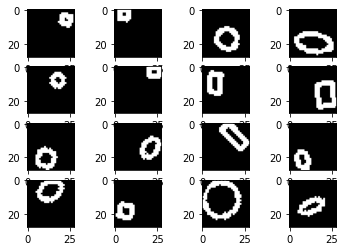

In [ ]:
x = next(iter(train_loader))
plt.figure()
for index, img in enumerate(x[0][:16]):
    plt.subplot(4,4,index+1)
    plt.imshow(img[0].view(28,28), cmap="Greys")

In [ ]:
def save_checkpoint(filepath, 
                    curr_epoch, 
                    arch, 
                    model,
                    losses, 
                    acc, 
                    num_classes, 
                    strip_fc,
                    optimizer,
                    scheduler,
                    lr,
                    weight_decay):
    checkpoint = {
        'curr_epoch': curr_epoch,
        'losses': losses,
        'acc': acc,
        'arch': arch,
        'num_classes': num_classes,
        'strip_fc': strip_fc,
        'state_dict': model.state_dict(),
        'optimizer_dict': optimizer.state_dict(),
        'scheduler_dict': scheduler.state_dict(),
        'lr': lr,
        'weight_decay': weight_decay
    }
    torch.save(checkpoint, filepath)

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Classifier(
        checkpoint['arch'],
        checkpoint['num_classes'],
        checkpoint['strip_fc']
    )
    model.load_state_dict(checkpoint['state_dict'])
    model = model.to(device)    

    return model, checkpoint['optimizer_dict'], checkpoint['scheduler_dict'], checkpoint['curr_epoch'], checkpoint['losses'], checkpoint['acc']

In [ ]:
def save_ssl(
    filepath, 
    model,
    losses, 
    optimizer,
    scheduler,
    ):

    model_state = model.state_dict(),
    checkpoint = {
        'losses': losses,
        'state_dict': model_state,
        'optimizer_dict': optimizer.state_dict(),
        'scheduler_dict': scheduler.state_dict(),
    }
    torch.save(checkpoint, filepath)

def load_ssl(filepath):
    checkpoint = torch.load(filepath)

    return checkpoint['state_dict'], checkpoint['optimizer_dict'], checkpoint['scheduler_dict'], checkpoint['losses']

In [ ]:
def set_requires_grad(model, val):
    for param in model.parameters():
        param.requires_grad = val

def get_output_shape(model, image_dim=(2,3,224,224)):
    return model(torch.rand(*(image_dim))).data.shape

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.

import torch
from torch import nn

from torchvision import models

class Encoder(nn.Module):

    def __init__(self, base_encoder, strip_fc=True, init_weights=False):
        super(Encoder, self).__init__()

        # create the encoder
        # num_classes is the output fc dimension
        self.arch = base_encoder
        built_encoder = models.__dict__[self.arch]
        self.encoder = built_encoder(pretrained=init_weights)
        self.strip_fc = strip_fc
            
        if strip_fc:
            if "vgg" in base_encoder:
                self.encoder.classifier = nn.Sequential(*list(self.encoder.classifier.children())[:-3])
            elif "densenet" in base_encoder:
                self.encoder.classifier = nn.Sequential(*list(self.encoder.classifier.children())[:-1])
            else:
                self.encoder = nn.Sequential(*list(self.encoder.children())[:-1])

        if base_encoder == "resnet18":
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
                *list(self.encoder.children())[1:3],
                *list(self.encoder.children())[4:],
            )
        
    def forward(self, x):
        r = self.encoder(x)
        r_flat = torch.squeeze(r)
        return r_flat

In [ ]:
class Projector(nn.Module):

    def __init__(self, proj_dims):
        super(Projector, self).__init__()

        in_dim = proj_dims[0]
        h_dim = proj_dims[1]
        out_dim = proj_dims[2]

        self.projector = nn.Sequential(
            nn.Linear(in_dim, h_dim, bias=False),
            nn.BatchNorm1d(h_dim),
            nn.ReLU(inplace=True),  # first layer
            nn.Linear(h_dim, h_dim, bias=False),
            nn.BatchNorm1d(h_dim),
            nn.ReLU(inplace=True),  # second layer
            nn.Linear(h_dim, out_dim, bias=False), # third layer
            nn.BatchNorm1d(out_dim, affine=False),
        )
    
    def forward(self, x):
        z = self.projector(x)
        return z

In [ ]:
class Predictor(nn.Module):

    def __init__(self, pred_dims):
        super(Predictor, self).__init__()
        emb_dim = pred_dims[0]
        pred_dim = pred_dims[1]

        self.predictor = nn.Sequential(
            nn.Linear(emb_dim, pred_dim, bias=False),
            nn.BatchNorm1d(pred_dim),
            nn.ReLU(inplace=True),  # hidden layer
            nn.Linear(pred_dim, emb_dim),
        )  # output layer

    def forward(self, x):
        z = self.predictor(x)
        return z

In [ ]:
class SimSiamModel(nn.Module):

    def __init__(self, base_encoder, proj_dims, pred_dims):
        super(SimSiamModel, self).__init__()
        self.encoder = Encoder(base_encoder)

        prev_dim = get_output_shape(self.encoder)[1]
        proj_dims = [prev_dim] + proj_dims
        
        self.projector = Projector(proj_dims)
        self.predictor = Predictor(pred_dims)

    def forward(self, x1, x2):
        r1 = self.encoder(x1)
        r2 = self.encoder(x2)

        z1 = self.projector(r1)
        z2 = self.projector(r2)

        p1 = self.predictor(z1)
        p2 = self.predictor(z2)

        return p1, p2, z1.detach(), z2.detach()

In [ ]:
# Source: https://github.com/sooonwoo/CL-Baselines (Modified)
# Author: sooonwoo
# License: BSD-2 Clause (Simplified)

import torch.nn.functional as F 

class SimCLRModel(nn.Module):
  
    def __init__(self, base_encoder, proj_dims):
        super(SimCLRModel, self).__init__()
        self.encoder = Encoder(base_encoder)
        
        prev_dim = get_output_shape(self.encoder)[1]

        self.proj_head = nn.Sequential(
            nn.Linear(prev_dim, proj_dims[0]),
            nn.ReLU(inplace=True),
            nn.Linear(proj_dims[0], proj_dims[1])
        )

    def forward(self, v1, v2):
        r1 = self.encoder(v1)
        r2 = self.encoder(v2)
        
        z1 = self.proj_head(torch.squeeze(r1))
        z2 = self.proj_head(torch.squeeze(r2))
        
        return z1, z2


In [ ]:
class Classifier(Encoder):
    """
    Build a classifier.
    Parameters
    ----------
    base_encoder : torch.nn.Module
        Base encoder model.
    dim : int, default=2048
        Feature dimension
    pred_dim : int, default=512
        Hidden dimension of classifier
    """

    def __init__(self, base_encoder, num_classes, strip_fc=True, init_weights=False):
        super(Classifier, self).__init__(base_encoder=base_encoder, strip_fc=strip_fc, init_weights=init_weights)
        self.num_classes = num_classes
        self.strip_fc = strip_fc
        self.prev_dim = get_output_shape(self.encoder)[1]
       
        # build a 2-layer classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.prev_dim, self.num_classes),
        )  # output layer

    def forward(self, x):
        """
        Forward step.

        Parameters
        ----------
        x : torch.Tensor
            View of image.
            
        Return
        ------
        z, c :
            Predicted embedding and class of the image.
        """
        # compute features for one view
        #with torch.no_grad():
        #    z = self.encoder(x)
        #    z_batched = torch.flatten(z, start_dim=1)
        z = self.encoder(x)
        z_batched = torch.squeeze(z)
        c = self.classifier(z_batched)

        return c


In [ ]:
class LinearProbeClassifier(nn.Module):

    def __init__(self, encoder, num_classes):
        super(LinearProbeClassifier, self).__init__()
        self.encoder = encoder
        try:
            self.arch = self.encoder.arch
        except: self.arch = "resnet18"
        try:
            self.strip_fc = self.encoder.strip_fc
        except: self.strip_fc = True
        self.num_classes = num_classes
        set_requires_grad(self.encoder, False)

        prev_dim = get_output_shape(self.encoder)[1]
        
        self.classifier = nn.Sequential(
            nn.Linear(prev_dim, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():
            r = self.encoder(x)
            r = r.view(len(x), 512)
        c = self.classifier(r)
        return c

In [ ]:
# Source: https://github.com/sadimanna/simclr_pytorch
# Author: sadimanna
# License: GPL-3.0

class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(SimCLR_Loss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature

        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size

        z = torch.cat((z_i, z_j), dim=0)

        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature

        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_samples = sim[self.mask].reshape(N, -1)
        
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N
        
        return loss

In [ ]:
# Linear probe parameters and initializations
sl_epochs = 100

def calc_acc(pred, lab):
    return sum([1 for p, l in zip(pred, lab) if p==l])/len(lab)

def batch_calc(model, criterion, images, labs):
    images = images.to(device)
    labs = labs.to(device)
    c = model(x=images)
    loss = criterion(c, labs)

    with torch.no_grad():
        g_true = labs.cpu()
        preds = torch.argmax(c.detach().cpu(), dim=-1)
        acc = calc_acc(preds, g_true)

    return loss, acc

def train_sl_epoch(model, train_loader, criterion, optimizer, scheduler):
    epoch_loss = []
    epoch_acc = []

    # switch to train mode
    model.train()

    for i, (images, labs) in enumerate(train_loader):
        loss, acc = batch_calc(model, criterion, images, labs)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss.append(loss.item())
        epoch_acc.append(acc)

    model.eval()

    return np.average(epoch_loss), np.average(epoch_acc)

def train_sl(model, train_loader, test_loader, sl_epochs, lr=0.003, weight_decay=1e-4, load=False):
    sl_losses = []
    sl_accs = []
    test_loss = []
    test_acc = []

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
                      model.parameters(), lr=lr, weight_decay=weight_decay
                  )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr, total_steps=sl_epochs*int(len(train_loader)), pct_start=0.3)
    
    if load:
        model, optimizer_dict, scheduler_dict, start_epoch, sl_losses, sl_accs = load_checkpoint("/content/gdrive/MyDrive/round_edge_tests/checkpoint_{}.pth".format(model.arch))
        optimizer.load_state_dict(optimizer_dict)
        scheduler.load_state_dict(scheduler_dict)

    else:
        start_epoch = 0

    for epoch in range(start_epoch, sl_epochs):
        print("Training SL Epoch {}/{}...".format(epoch+1, sl_epochs))
        sl_loss, sl_acc =  train_sl_epoch(model, train_loader, criterion, optimizer, scheduler)
        sl_losses.append(sl_loss)
        sl_accs.append(sl_acc)

        print(" SL Loss: {}".format(sl_losses[-1]))
        print(" SL Accuracy: {}".format(sl_accs[-1]))
        save_checkpoint(
            filepath="/content/gdrive/MyDrive/round_edge_tests/checkpoint_{}.pth".format(model.arch), 
            curr_epoch=epoch+1, 
            arch=model.arch, 
            model=model,
            losses=sl_losses, 
            acc=sl_accs, 
            num_classes=model.num_classes, 
            strip_fc=model.strip_fc,
            optimizer=optimizer,
            scheduler=scheduler,
            lr=lr,
            weight_decay=weight_decay
            )

    model.eval()
    for i, (images, labs) in enumerate(test_loader):
        loss, acc = batch_calc(model, criterion, images, labs)

        test_loss.append(loss.item())
        test_acc.append(acc)
        

    return sl_losses, sl_accs, np.average(test_loss), np.average(test_acc)

In [ ]:
def train_simclr_epoch(
    model, 
    optimizer, 
    scheduler, 
    train_loader,
    criterion
    ):

    epoch_loss = []

    for i, (images, labs) in enumerate(train_loader):
        images[0] = images[0].squeeze().to(device)
        images[1] = images[1].squeeze().to(device)
        z1, z2 = model(v1=images[0], v2=images[1])
        loss = criterion(z1, z2)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        epoch_loss.append(loss.item())

    return np.average(epoch_loss)

def train_simclr( 
    model,
    optimizer,
    scheduler,
    train_loader, 
    epochs, 
    temp=0.5
    ):
    
    losses = []
    
    criterion = SimCLR_Loss(batch_size=512, temperature=temp).to(device)
  
    for epoch in range(0, epochs):
        print("Training Epoch {}/{}...".format(epoch+1, epochs))
        loss = train_simclr_epoch(
            model=model, 
            optimizer=optimizer, 
            scheduler=scheduler, 
            train_loader=train_loader,
            criterion=criterion
        )

        losses.append(loss)
        print("Loss: {}".format(loss))

    save_ssl(
    filepath="/content/gdrive/MyDrive/round_edge_tests/checkpoint_ssl.pth", 
    model=model,
    losses=losses, 
    optimizer=optimizer,
    scheduler=scheduler,
    )

    return losses

In [ ]:
# Training Params
name = "resnet18"
proj_dims = [2048, 128]
max_epochs = 200
num_classes = 2
strip_fc = True
load_ssl_model = False
load_model = False
ssl_mode = False
linear_probe = True
init_weights = False # True means use intial pretrained weights

lr = 0.5
momentum = 0.9
weight_decay = 1e-4
temp = 0.5
scheduler_steps = max_epochs*int(len(train_loader))

In [ ]:
if ssl_mode and not load_ssl_model:
    model = SimCLRModel(base_encoder=name, proj_dims=proj_dims)
    model = model.to(device)
    optimizer = torch.optim.SGD(
                    model.parameters(), lr, momentum=momentum, weight_decay=weight_decay
                )
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=lr, total_steps=scheduler_steps, pct_start=0.3)

In [ ]:
if ssl_mode and not load_ssl_model:
    hist_losses = train_simclr(
        model=model, 
        optimizer=optimizer,
        scheduler=scheduler,
        train_loader=ssl_train_loader,
        epochs=max_epochs,
    )

In [ ]:
def progress_plot(data, x_lab, y_lab):
  plt.figure()
  plt.xlabel(x_lab)
  plt.ylabel(y_lab)
  plt.plot(data)

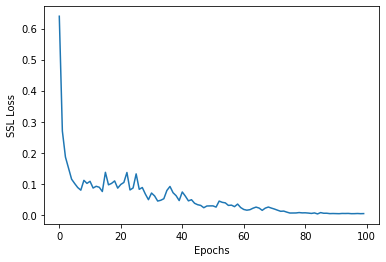

In [ ]:
if linear_probe:
    #model_dict, _, _, losses = load_ssl("/content/gdrive/MyDrive/round_edge_tests/checkpoint_ssl.pth")
    #model = SimCLRModel(base_encoder=name, proj_dims=proj_dims)

    model, _, _, _, losses, accs = load_checkpoint("/content/gdrive/MyDrive/round_edge_tests/checkpoint_sl_all_resnet18.pth")
    ##model = Classifier(base_encoder=name, num_classes=num_classes, strip_fc = strip_fc, init_weights=init_weights)

    ##model.load_state_dict(model_dict[0])
    model.to('cpu')

    progress_plot(data=losses, x_lab="Epochs", y_lab="SSL Loss")
    ##progress_plot(data=accs, x_lab="Epochs", y_lab="SL Accuracy")
    classifier = LinearProbeClassifier(encoder=model.encoder, num_classes=num_classes)
    set_requires_grad(classifier.encoder, False)

else:
    classifier = Classifier(base_encoder=name, num_classes=num_classes, strip_fc=strip_fc, init_weights=init_weights)
    set_requires_grad(classifier.encoder, False)

classifier = classifier.to(device)

In [ ]:
sl_losses, sl_accs, test_loss, test_acc, = train_sl(classifier, train_loader=train_loader, test_loader=test_loader, sl_epochs=sl_epochs, load=load_model)

Training SL Epoch 1/100...
 SL Loss: 0.5124677654943968
 SL Accuracy: 0.8340871710526315
Training SL Epoch 2/100...
 SL Loss: 0.3370751816975443
 SL Accuracy: 0.9964021381578947
Training SL Epoch 3/100...
 SL Loss: 0.21186890100177966
 SL Accuracy: 0.9977384868421053
Training SL Epoch 4/100...
 SL Loss: 0.12981225628601878
 SL Accuracy: 0.9985608552631579
Training SL Epoch 5/100...
 SL Loss: 0.08162702855310942
 SL Accuracy: 0.9978412828947368
Training SL Epoch 6/100...
 SL Loss: 0.052980300823324604
 SL Accuracy: 0.9986636513157895
Training SL Epoch 7/100...
 SL Loss: 0.03725981859392241
 SL Accuracy: 0.9982524671052632
Training SL Epoch 8/100...
 SL Loss: 0.026979202012482443
 SL Accuracy: 0.9988692434210527
Training SL Epoch 9/100...
 SL Loss: 0.022196011323677867
 SL Accuracy: 0.9979440789473685
Training SL Epoch 10/100...
 SL Loss: 0.016767237335443497
 SL Accuracy: 0.9988692434210527
Training SL Epoch 11/100...
 SL Loss: 0.014967710956146843
 SL Accuracy: 0.9981496710526315
Train

SL model test loss: 8.164592509274371e-05


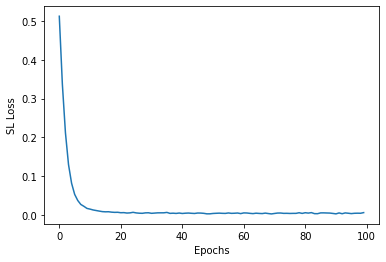

In [ ]:
progress_plot(sl_losses, "Epochs", "SL Loss")
print("SL model test loss:", test_loss)

SL model test accuracy: 1.0


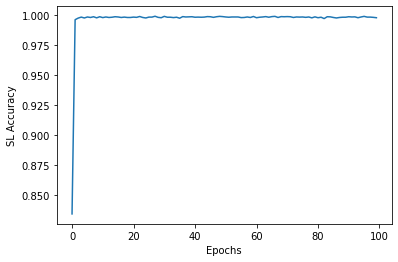

In [ ]:
progress_plot(sl_accs, "Epochs", "SL Accuracy")
print("SL model test accuracy:", test_acc)